# Partie 1

## 0. Chargement des dépendances

In [ ]:
# Montage du drive google pour charger les données
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Filtre les erreurs
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Configure l'affichage des tableaux NumPy : affiche jusqu'à 10 000 éléments et supprime la notation scientifique.
import numpy as np
np.set_printoptions(threshold=10000,suppress=True)

In [ ]:
import time
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBClassifier




## 1. Chargement et préparation des données

In [ ]:
# Importation des données avec pandas
data = pd.read_csv('drive/MyDrive/credit_scoring.csv', sep=';')

# Affichage des premières lignes du dataset pour vérifier son contenu
print(data.head())

nom_cols = data.columns.values[:-1] # first items without Status

# Conversion en numpy array
X = data.drop(columns=["Status"]).values # Sélection des colonnes de caractéristique
y = data["Status"].values # Sélection de la variable cible

# Analyser les propriétés des données
print("Taille de l'échantillon :", data.shape) # Taille de l'échantillon

# Pourcentage d'exemples positifs et négatifs
positive_count = np.sum(y == 1)
negative_count = np.sum(y == 0)
total_count = len(y)
print("Pourcentage d'exemples positifs :", (positive_count / total_count) * 100, "%")
print("Pourcentage d'exemples négatifs :", (negative_count / total_count) * 100, "%")

# Séparation des données en jeu d'apprentissage et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)

# Vérification des tailles
print("Taille du jeu d'apprentissage :", X_train.shape)
print("Taille du jeu de test :", X_test.shape)

   Seniority  Home  Time   Age  Marital  Records  Job  Expenses  Income  \
0        9.0   1.0  60.0  30.0      0.0      1.0  1.0      73.0   129.0   
1       17.0   1.0  60.0  58.0      1.0      1.0  0.0      48.0   131.0   
2       10.0   0.0  36.0  46.0      0.0      2.0  1.0      90.0   200.0   
3        0.0   1.0  60.0  24.0      1.0      1.0  0.0      63.0   182.0   
4        0.0   1.0  36.0  26.0      1.0      1.0  0.0      46.0   107.0   

   Assets  Debt  Amount   Price  Status  
0     0.0   0.0   800.0   846.0       1  
1     0.0   0.0  1000.0  1658.0       1  
2  3000.0   0.0  2000.0  2985.0       0  
3  2500.0   0.0   900.0  1325.0       1  
4     0.0   0.0   310.0   910.0       1  
Taille de l'échantillon : (4375, 14)
Pourcentage d'exemples positifs : 72.20571428571428 %
Pourcentage d'exemples négatifs : 27.794285714285717 %
Taille du jeu d'apprentissage : (2187, 13)
Taille du jeu de test : (2188, 13)


## 2. Apprentissage et évaluation de modèles

In [ ]:
# Les modèles à comparer
models = {
    "CART": DecisionTreeClassifier(random_state=1),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "MLP": MLPClassifier(hidden_layer_sizes=(40, 20), random_state=1, max_iter=1000)
}

# Entrainnement du modèle
for model_name, model in models.items():
    model.fit(X_train, y_train)



In [ ]:
def evaluate_models(models, X_test, y_test):

    results = {}

    for model_name, model in models.items():
        # Prédictions
        y_pred = model.predict(X_test)

        results[model_name] = {
            "cm": confusion_matrix(y_test, y_pred),
            "accuracy": accuracy_score(y_test, y_pred),
            "precision": precision_score(y_test, y_pred),
            "recall": recall_score(y_test, y_pred)
        }

    return results

def show_results(results):
    for model_name, metrics in results.items():
        print(f"Résultats pour le modèle {model_name}:")
        print(f"Matrice de confusion:\n{metrics['cm']}")
        print(f"Accuracy : {metrics['accuracy']:.2f}")
        print(f"Précision : {metrics['precision']:.2f}")
        print(f"Rappel : {metrics['recall']:.2f}")
        print(f"------")

# Appel de la fonction pour évaluer et comparer les modèles
results = evaluate_models(models, X_test, y_test)

show_results(results)

Résultats pour le modèle CART:
Matrice de confusion:
[[ 325  279]
 [ 318 1266]]
Accuracy : 0.73
Précision : 0.82
Rappel : 0.80
------
Résultats pour le modèle KNN:
Matrice de confusion:
[[ 189  415]
 [ 187 1397]]
Accuracy : 0.72
Précision : 0.77
Rappel : 0.88
------
Résultats pour le modèle MLP:
Matrice de confusion:
[[ 285  319]
 [ 342 1242]]
Accuracy : 0.70
Précision : 0.80
Rappel : 0.78
------


Dans le cas métier du crédit scoring, la mesure la plus importante entre le rappel et la précision est bien la précision, afin d'éviter les faux positifs.

Si l'on considère une matrice de confusion dans le cas métier du crédit scoring, elle pourrait se présenter comme suit :
```

                    | Solvable (Positif)  | Non solvable (Négatif)
--------------------|---------------------|-------------------------
Prédit Solvable     | Vrais Positifs (VP) | Faux Positifs (FP)
Prédit Non Solvable | Faux Négatifs (FN)  | Vrais Négatifs (VN)
```

* VP : Bon emprunteur identifié comme bon (vrai positif).
* FP : Mauvais emprunteur identifié comme bon (faux positif).
* FN : Bon emprunteur identifié comme mauvais (faux négatif).
* VN : Mauvais emprunteur identifié comme mauvais (vrai négatif).

Dans cette optique, nous souhaitons :

* Minimiser FP (mauvais emprunteur identifié comme bon).
* Maximiser VP (bon emprunteur identifié correctement).

et éventuellement;

* Minimiser FN (bon emprunteur identifié comme mauvais).

Dans notre TP nous nous concentrerons exclusivement sur la **précision**. Une entreprise pourrait utiliser une moyenne harmonique avec un poids plus faible sur le FN selon son business plan.


## 3. Normalisation des variables continues

In [ ]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

models_on_scaled = {
    "CART_on_scaled": DecisionTreeClassifier(random_state=1),
    "KNN_on_scaled": KNeighborsClassifier(n_neighbors=5),
    "MLP_on_scaled": MLPClassifier(hidden_layer_sizes=(40, 20), random_state=1, max_iter=1000)
}

# Entrainnement du modèle
for model_name, model in models_on_scaled.items():
    model.fit(X_train_scaled, y_train)

# Comparaison des modèles
results_on_normalized = evaluate_models(models_on_scaled, X_test_scaled, y_test)

show_results(results_on_normalized)

def best_model_by_precision(data):
    # Vérifie que le dictionnaire n'est pas vide
    if not data:
        return None

    # Utilise max() pour trouver l'élément avec la meilleure précision
    best_key, best_value = max(data.items(), key=lambda item: item[1].get("precision", 0))
    best_value["name"] = best_key;
    # Retourne l'élément avec la meilleure précision
    return best_value

best_model = best_model_by_precision(results | results_on_normalized)



Résultats pour le modèle CART_on_scaled:
Matrice de confusion:
[[ 325  279]
 [ 315 1269]]
Accuracy : 0.73
Précision : 0.82
Rappel : 0.80
------
Résultats pour le modèle KNN_on_scaled:
Matrice de confusion:
[[ 283  321]
 [ 236 1348]]
Accuracy : 0.75
Précision : 0.81
Rappel : 0.85
------
Résultats pour le modèle MLP_on_scaled:
Matrice de confusion:
[[ 314  290]
 [ 173 1411]]
Accuracy : 0.79
Précision : 0.83
Rappel : 0.89
------


In [ ]:
print(f"Le meilleur modèle par rapport à la précision est : {best_model['name']}")

Le meilleur modèle par rapport à la précision est : MLP_on_scaled


In [ ]:
if best_model['name'].endswith("on_scaled"):
  X_train = X_train_scaled
  X_test = X_test_scaled


Le **meilleurs modèle** à ce stade pour ces données et ce cas métier est donc **MLP sur des données normalisées** pour avoir la meilleurs précision.

## 4. Sélection de variables

['Seniority' 'Home' 'Time' 'Age' 'Marital' 'Records' 'Job' 'Expenses'
 'Income' 'Assets' 'Debt' 'Amount' 'Price']
['Income' 'Seniority' 'Price' 'Amount' 'Age' 'Assets' 'Expenses' 'Records'
 'Time' 'Job' 'Debt' 'Home' 'Marital']


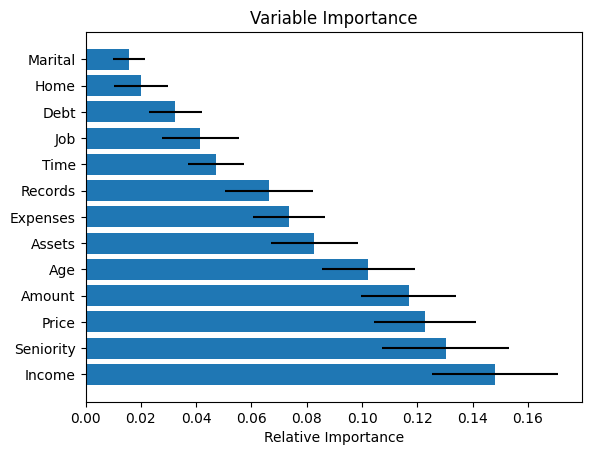

In [ ]:
from sklearn.ensemble import RandomForestClassifier

#clf = MLPClassifier(hidden_layer_sizes=(40, 20), random_state=1, max_iter=1000)

clf = RandomForestClassifier(n_estimators=1000,random_state=1)
clf.fit(X_train, y_train)
importances=clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],axis=0)
sorted_idx = np.argsort(importances)[::-1]
features = nom_cols

print(nom_cols)

print(features[sorted_idx])


padding = np.arange(X_train.size/len(X_train)) + 0.5
plt.barh(padding, importances[sorted_idx],xerr=std[sorted_idx], align='center')
plt.yticks(padding, features[sorted_idx])
plt.xlabel("Relative Importance")
plt.title("Variable Importance")
plt.show()

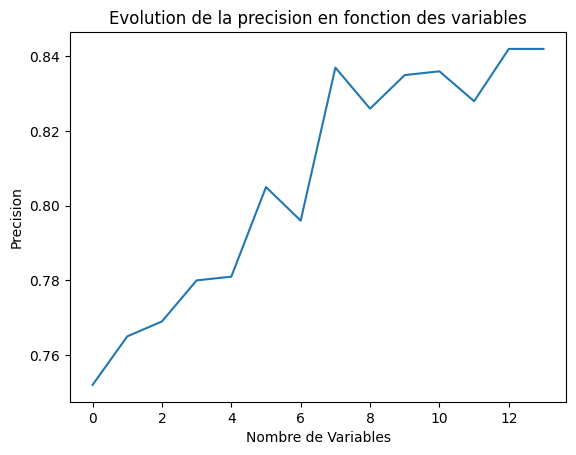

In [ ]:


best_model_instance = MLPClassifier(hidden_layer_sizes=(40, 20), random_state=1, max_iter=1000)
scores=np.zeros(X_train.shape[1]+1)
for f in np.arange(0, X_train.shape[1]+1):
  X1_f = X_train[:,sorted_idx[:f+1]]
  X2_f = X_test [:,sorted_idx[:f+1]]
  best_model_instance.fit(X1_f,y_train)
  y_pred=best_model_instance.predict(X2_f)
  scores[f]=np.round(precision_score(y_test,y_pred),3)
plt.plot(scores)
plt.xlabel("Nombre de Variables")
plt.ylabel("Precision")
plt.title("Evolution de la precision en fonction des variables")
plt.show()

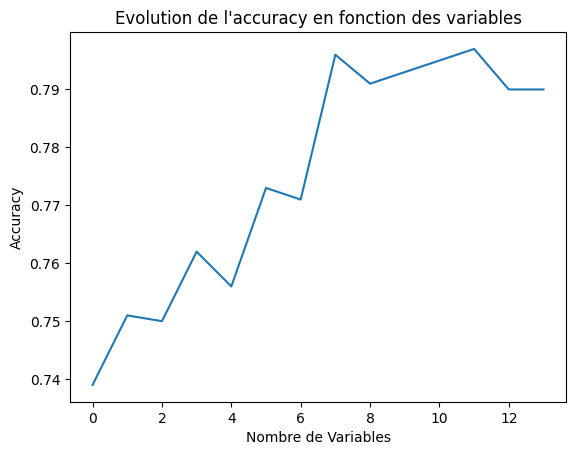

In [ ]:

best_model_instance = MLPClassifier(hidden_layer_sizes=(40, 20), random_state=1, max_iter=1000)
scores=np.zeros(X_train.shape[1]+1)
for f in np.arange(0, X_train.shape[1]+1):
  X1_f = X_train[:,sorted_idx[:f+1]]
  X2_f = X_test [:,sorted_idx[:f+1]]
  best_model_instance.fit(X1_f,y_train)
  y_pred=best_model_instance.predict(X2_f)
  scores[f]=np.round(accuracy_score(y_test,y_pred),3)
plt.plot(scores)
plt.xlabel("Nombre de Variables")
plt.ylabel("Accuracy")
plt.title("Evolution de l'accuracy en fonction des variables")
plt.show()

On remarque un pic à 7 variables. Les calculs au delà des 7 premières varibles sont plus couteux pour peu voir pas de gains en precision et en accuracy.

In [ ]:
X_train_selected = X_train[:,sorted_idx[:7]]
X_test_selected = X_test[:,sorted_idx[:7]]

## 5. Paramétrage du meilleur algorithme.



In [ ]:
# Fonction de score personnalisé
def custom_score(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')  # Pour multi-classes
    return (accuracy + precision) / 2

scorer = make_scorer(custom_score, greater_is_better=True)

param_grid = {
    'hidden_layer_sizes': [(20, 10), (10, 20)],  # Test de différentes architectures de couches
    'activation': ['relu', 'tanh'],  # Fonction d'activation
    'solver': ['adam', 'sgd'],  # Algorithmes d'optimisation
    'alpha': [0.0001, 0.001, 0.01],  # Regularisation
    'learning_rate': ['constant', 'adaptive']  # Taux d'apprentissage
}

# GridSearchCV pour optimiser les paramètres
grid_search = GridSearchCV(MLPClassifier(random_state=1, max_iter=1000), param_grid, scoring=scorer, cv=5, n_jobs=-1)
grid_search.fit(X_train_selected, y_train)




GridSearchCV(cv=5, estimator=MLPClassifier(max_iter=1000, random_state=1),
             n_jobs=-1,
             param_grid={'activation': ['relu', 'tanh'],
                         'alpha': [0.0001, 0.001, 0.01],
                         'hidden_layer_sizes': [(20, 10), (10, 20)],
                         'learning_rate': ['constant', 'adaptive'],
                         'solver': ['adam', 'sgd']},
             scoring=make_scorer(custom_score, response_method='predict'))

In [ ]:
print(grid_search.best_params_)


{'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (10, 20), 'learning_rate': 'constant', 'solver': 'adam'}


## 6. Création d’un pipeline

In [ ]:
# Créer le pipeline
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),  # Mise à l'échelle des données
    ('mlp', grid_search.best_estimator_)  # Classificateur MLP
])

print (grid_search.best_estimator_)

pipeline.fit(X_train_selected, y_train)

# Sauvegarder le pipeline dans un pickle
with open('mlp_pipeline.pkl', 'wb') as f:
    pickle.dump(pipeline, f)


MLPClassifier(alpha=0.001, hidden_layer_sizes=(10, 20), max_iter=1000,
              random_state=1)


Test du pickle

In [ ]:
# Chargement du pickle
with open('mlp_pipeline.pkl', 'rb') as f:
    loaded_pipeline = pickle.load(f)

# Faire les prédictions sur l'ensemble de test
y_pred = loaded_pipeline.predict(X_test_selected)

# Calculer le score personnalisé sur l'ensemble de test
final_score = custom_score(y_test, y_pred)
print(f"Final Custom Score on test set: {final_score:.3f}")

# Afficher la matrice de confusion
print("Matrice de confusion :\n", confusion_matrix(y_test, y_pred))

Final Custom Score on test set: 0.769
Matrice de confusion :
 [[ 239  365]
 [ 123 1461]]


## 7. Comparaison de plusieurs algorithmes d’apprentissage

In [ ]:
# Custom score function
def custom_score(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')  # For multi-class
    return (accuracy + precision) / 2

# Dictionnaire d'algorithmes
clfs = {
    'CART': DecisionTreeClassifier(random_state=1),
    'ID3': DecisionTreeClassifier(criterion='entropy', random_state=1),
    'DecisionStump': DecisionTreeClassifier(max_depth=1, random_state=1),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Bagging': BaggingClassifier(random_state=1),
    'AdaBoost': AdaBoostClassifier(random_state=1),
    'RandomForest': RandomForestClassifier(random_state=1),
    'XGBoost': XGBClassifier(random_state=1, use_label_encoder=False, eval_metric='logloss'),
    'MLP': MLPClassifier(max_iter=1000, random_state=1)
}

# Hyperparamètres à tester pour GridSearchCV
param_grids = {
    'CART': {'classifier__max_depth': [3, 5, 10]},
    'ID3': {'classifier__max_depth': [3, 5, 10]},
    'DecisionStump': {'classifier__max_depth': [1, 2]},
    'KNN': {'classifier__n_neighbors': [3, 5, 7]},
    'Bagging': {'classifier__n_estimators': [50, 100, 200]},
    'AdaBoost': {'classifier__n_estimators': [50, 100, 200]},
    'RandomForest': {'classifier__n_estimators': [100, 200, 300]},
    'XGBoost': {'classifier__n_estimators': [100, 200, 300]},
    'MLP': {
        'classifier__hidden_layer_sizes': [(20,10), (10, 20)],  # Test de différentes architectures de couches
        'classifier__activation': ['relu', 'tanh'],  # Fonction d'activation
        'classifier__solver': ['adam', 'sgd'],  # Algorithmes d'optimisation
        'classifier__alpha': [0.0001, 0.001, 0.01],  # Regularisation
        'classifier__learning_rate': ['constant', 'adaptive']  # Taux d'apprentissage
    }
}

# Pipeline pour normalisation et classification
pipelines = {
    name: Pipeline([
        ('scaling', MinMaxScaler()),
        ('classifier', clf)
    ])
    for name, clf in clfs.items()
}

# Fonction pour appliquer la sélection des variables et ensuite GridSearchCV
def run_classifiers(pipelines, param_grids):
    results = []
    kf = KFold(n_splits=10, shuffle=True, random_state=0)
    scorer = make_scorer(custom_score, greater_is_better=True)

    for name, pipeline in pipelines.items():
        print(f"Training {name}...")
        start_time = time.time()

        # GridSearchCV pour hyperparamètre tuning sur les variables sélectionnées
        grid_search = GridSearchCV(pipeline, param_grids[name], cv=kf, scoring=scorer, n_jobs=-1)
        grid_search.fit(X_train_selected, y_train)

        elapsed_time = time.time() - start_time

        # Custom score details for each model
        print(f"Custom Score for {name}: {grid_search.best_score_:.3f}")

        results.append({
            "Model": name,
            "Best Params": grid_search.best_params_,
            "Mean Custom Score": grid_search.best_score_,
            "Std Custom Score": np.std(cross_val_score(grid_search.best_estimator_, X_train_selected, y_train, cv=kf, scoring=scorer)),
            "Execution Time (s)": elapsed_time
        })
        print(f"Best parameters chosen for {name}: {grid_search.best_params_}")

    return pd.DataFrame(results)

# Lancer la comparaison
results = run_classifiers(pipelines, param_grids)
print(results)

# Recherche du meilleur modèle
best_model_name = results.iloc[results['Mean Custom Score'].idxmax()]['Model']
best_pipeline = pipelines[best_model_name]
print(f"\nBest model: {best_model_name}")

# Réentraînement du meilleur modèle et sauvegarde
best_pipeline.fit(X_train_selected, y_train)
y_pred = best_pipeline.predict(X_test_selected)

# Afficher le score personnalisé sur l'ensemble de test
best_score = custom_score(y_test, y_pred)
print(f"Custom Score on test set: {best_score:.3f}")

# Sauvegarde du modèle
with open('best_pipeline.pkl', 'wb') as f:
  pickle.dump(best_pipeline, f)
print(f"Best model saved as 'best_pipeline.pkl'")



Training CART...
Custom Score for CART: 0.735
Best parameters chosen for CART: {'classifier__max_depth': 5}
Training ID3...
Custom Score for ID3: 0.719
Best parameters chosen for ID3: {'classifier__max_depth': 5}
Training DecisionStump...
Custom Score for DecisionStump: 0.707
Best parameters chosen for DecisionStump: {'classifier__max_depth': 2}
Training KNN...
Custom Score for KNN: 0.708
Best parameters chosen for KNN: {'classifier__n_neighbors': 7}
Training Bagging...
Custom Score for Bagging: 0.736
Best parameters chosen for Bagging: {'classifier__n_estimators': 100}
Training AdaBoost...
Custom Score for AdaBoost: 0.745
Best parameters chosen for AdaBoost: {'classifier__n_estimators': 50}
Training RandomForest...
Custom Score for RandomForest: 0.733
Best parameters chosen for RandomForest: {'classifier__n_estimators': 200}
Training XGBoost...
Custom Score for XGBoost: 0.729
Best parameters chosen for XGBoost: {'classifier__n_estimators': 100}
Training MLP...
Custom Score for MLP: 0.

# Partie 2

## 1. Dans un premier temps nous allons considérer que les caractéristiques continues

Dimensions des données : (688, 16)
  0      1      2  3  4  5  6     7  8  9   10 11 12   13   14 15
0  b  30.83  0.000  u  g  w  v  1.25  t  t   1  f  g  202    0  +
1  a  58.67  4.460  u  g  q  h  3.04  t  t   6  f  g   43  560  +
2  a  24.50  0.500  u  g  q  h  1.50  t  f   0  f  g  280  824  +
3  b  27.83  1.540  u  g  w  v  3.75  t  t   5  t  g  100    3  +
4  b  20.17  5.625  u  g  w  v  1.71  t  f   0  f  s  120    0  +
Exemples de y :
['+' '-']
Aperçu des données numériques avec NaN :
      1      2     7    10     13     14
0  30.83  0.000  1.25  1.0  202.0    0.0
1  58.67  4.460  3.04  6.0   43.0  560.0
2  24.50  0.500  1.50  0.0  280.0  824.0
3  27.83  1.540  3.75  5.0  100.0    3.0
4  20.17  5.625  1.71  0.0  120.0    0.0
Forme des données avant suppression : (688, 6)
Forme des données après suppression : (666, 6)
Aperçu des données sans NaN :
      1      2     7    10     13     14
0  30.83  0.000  1.25  1.0  202.0    0.0
1  58.67  4.460  3.04  6.0   43.0  560.0
2  24.50 

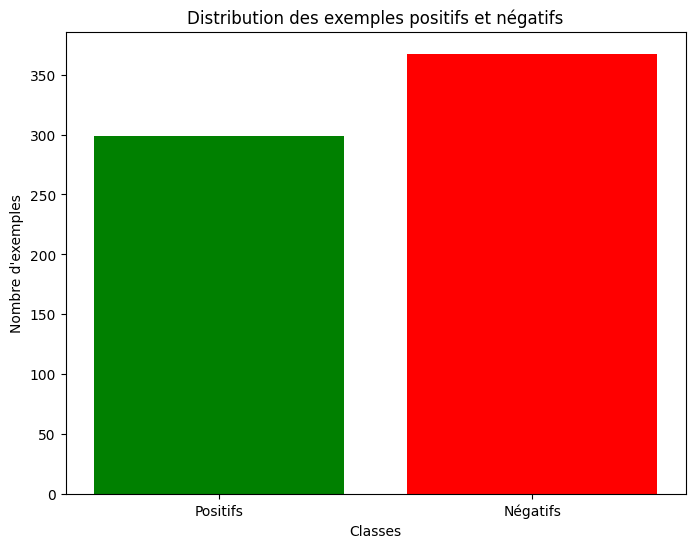

Exemples de la cible binarisée :
[1 1 1 1 1 1 1 1 1 1]
Nombre d'exemples positifs (1) : 299
Nombre d'exemples négatifs (0) : 367
Résultats avec StandardScaler :
Training Logistic Regression...
AUC for Logistic Regression: 0.828
Training SVM...
AUC for SVM: 0.839
Training Random Forest...
AUC for Random Forest: 0.848
                 Model  Mean AUC  Execution Time (s)
0  Logistic Regression  0.827673            0.034792
1                  SVM  0.839306            0.259541
2        Random Forest  0.848286            0.495193

Résultats avec MinMaxScaler :
Training Logistic Regression...
AUC for Logistic Regression: 0.785
Training SVM...
AUC for SVM: 0.826
Training Random Forest...
AUC for Random Forest: 0.851
                 Model  Mean AUC  Execution Time (s)
0  Logistic Regression  0.785051            0.005318
1                  SVM  0.826126            0.170436
2        Random Forest  0.851047            0.734832


In [101]:
import numpy as np
np.set_printoptions(threshold=10000, suppress=True)
import pandas as pd
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.model_selection import KFold, cross_val_score
import time
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

file_path = "drive/MyDrive/credit.data"
data = pd.read_csv(file_path, sep="\t", header=None)
data_cleaned = data.dropna()

# Affichage d'un aperçu des données nettoyées
print(f"Dimensions des données : {data_cleaned.shape}")
print(data_cleaned.head())

# Séparation des caractéristiques et de la cible
X = data_cleaned.iloc[:, :-1]  # Toutes les colonnes sauf la dernière
y = data_cleaned.iloc[:, -1]   # La dernière colonne (classe cible)

# Vérification
print(f"Exemples de y :\n{y.unique()}")

# Transformation du DataFrame en tableau NumPy
data_array = data_cleaned.values

# Séparation des variables caractéristiques (X) et de la cible (y)
X = data_array[:, :-1]  # Toutes les colonnes sauf la dernière
y = data_array[:, -1]   # Dernière colonne

# Remplacement des valeurs manquantes (?) par NaN
data_cleaned.replace('?', np.nan, inplace=True)

# Indices des colonnes catégorielles
col_cat = [0, 3, 4, 5, 6, 8, 9, 11, 12]

 # Indices des colonnes numériques
numeric_columns = [i for i in range(X.shape[1]) if i not in col_cat]
numeric_data = data_cleaned.iloc[:, numeric_columns]

# Conversion en type float
numeric_data = numeric_data.astype(float)

# Vérification
print("Aperçu des données numériques avec NaN :")
print(numeric_data.head())

# Suppression des lignes contenant des NaN
numeric_data_cleaned = numeric_data.dropna()

# Vérification après suppression
print(f"Forme des données avant suppression : {numeric_data.shape}")
print(f"Forme des données après suppression : {numeric_data_cleaned.shape}")

# Aperçu des données nettoyées
print("Aperçu des données sans NaN :")
print(numeric_data_cleaned.head())

# Suppression des lignes contenant des NaN dans X
valid_indices = numeric_data_cleaned.index  # Indices des lignes valides après nettoyage
y_cleaned = y[valid_indices]  # Garder les cibles correspondant à ces indices

# Comptage des exemples positifs et négatifs
positive_count = (y_cleaned == '+').sum()
negative_count = (y_cleaned == '-').sum()

print(f"Nombre d'exemples positifs : {positive_count}")
print(f"Nombre d'exemples négatifs : {negative_count}")

# Affichage de l'histogramme
plt.figure(figsize=(8, 6))
plt.bar(['Positifs', 'Négatifs'], [positive_count, negative_count], color=['green', 'red'])
plt.title("Distribution des exemples positifs et négatifs")
plt.xlabel("Classes")
plt.ylabel("Nombre d'exemples")
plt.show()

# Binarisation de la variable cible
y_binarized = (y_cleaned == '+').astype(int)

# Vérification de la transformation
print("Exemples de la cible binarisée :")
print(y_binarized[:10])

# Comptage des exemples binarisés
positive_count = (y_binarized == 1).sum()
negative_count = (y_binarized == 0).sum()
print(f"Nombre d'exemples positifs (1) : {positive_count}")
print(f"Nombre d'exemples négatifs (0) : {negative_count}")

def run_classifiers(pipelines, X_train_selected, y_train):
    results = []
    kf = KFold(n_splits=10, shuffle=True, random_state=0)

    # Utilisation de l'AUC comme score personnalisé
    auc_scorer = make_scorer(roc_auc_score, needs_proba=True, greater_is_better=True)

    for name, pipeline in pipelines.items():
        print(f"Training {name}...")
        start_time = time.time()

        # Entraînement du modèle sans recherche d'hyperparamètres
        pipeline.fit(X_train_selected, y_train)
        elapsed_time = time.time() - start_time
        # AUC details for each model
        mean_auc_score = cross_val_score(pipeline, X_train_selected, y_train, cv=kf, scoring=auc_scorer).mean()
        print(f"AUC for {name}: {mean_auc_score:.3f}")

        results.append({
            "Model": name,
            "Mean AUC": mean_auc_score,
            "Execution Time (s)": elapsed_time
        })

    return pd.DataFrame(results)

pipelines = {
    'Logistic Regression': Pipeline([('clf', LogisticRegression(max_iter=1000))]),
    'SVM': Pipeline([('clf', SVC(probability=True))]),
    'Random Forest': Pipeline([('clf', RandomForestClassifier())])
}

X_train_selected = numeric_data_cleaned.values
y_train = y_binarized

# Normalisation avec StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)

# Normalisation avec MinMaxScaler (optionnel)
min_max_scaler = MinMaxScaler()
X_train_minmax_scaled = min_max_scaler.fit_transform(X_train_selected)

# Exécuter la fonction run_classifiers sur les données normalisées
print("Résultats avec StandardScaler :")
results_standard = run_classifiers(pipelines, X_train_scaled, y_train)
print(results_standard)

print("\nRésultats avec MinMaxScaler :")
results_minmax = run_classifiers(pipelines, X_train_minmax_scaled, y_train)
print(results_minmax)

## 2. Nous allons maintenant considérer la totalité de la base originale

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, roc_curve

file_path = 'drive/MyDrive/credit.data'
data_file = pd.read_csv(file_path, delimiter='\t', header=None)
data = data_file.values
X = data[:, :-1]
y = data[:, -1]

print(X)
print(y)

print("Taille du jeu de données:", X.shape)

col_cat = [0, 3, 4, 5, 6, 8, 9, 11, 12]  # Indices des colonnes catégorielles
col_num = [i for i in range(X.shape[1]) if i not in col_cat]  # Indices des colonnes numériques


In [ ]:
# Pour les variables catégorielles
X_cat = np.copy(X[:, col_cat])
for col_id in range(len(col_cat)):
  unique_val, val_idx = np.unique(X_cat[:, col_id], return_inverse=True)
  X_cat[:, col_id] = val_idx
imp_cat = SimpleImputer(missing_values=0, strategy='most_frequent')
X_cat[:, range(5)] = imp_cat.fit_transform(X_cat[:, range(5)])
# Pour les variables numériques
X_num = np.copy(X[:, col_num])
X_num[X_num == '?'] = np.nan
X_num = X_num.astype(float)
imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')
X_num = imp_num.fit_transform(X_num)

In [ ]:
# Binariser les etiquettes cibles
y = np.array([1 if label == '+' else 0 for label in y])
print(y)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 1 1 1 1 

In [ ]:
# Conversion données cat en donnees num
X_cat_bin = OneHotEncoder().fit_transform(X_cat).toarray()

In [ ]:
# Merge des variables num et cat
X_merged = np.hstack((X_cat, X_num))
print (X_merged.shape)

(688, 15)


In [ ]:
# On scale les données
minmax_scaler = MinMaxScaler()
X = minmax_scaler.fit_transform(X_merged)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)


In [ ]:
# Définition des classifieurs à utiliser
clfs = {
    'SVM': SVC(kernel='linear', random_state=1, probability=True),  # Classifieur SVM avec un noyau linéaire
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=1)  # Classifieur Random Forest avec 100 arbres
}

# Pipeline pour normalisation (MinMaxScaler) et classification
pipelines = {
    name: Pipeline([
        ('scaling', MinMaxScaler()),  # Normalisation des données avec MinMaxScaler
        ('classifier', clf)           # Application du classifieur
    ])
    for name, clf in clfs.items()
}

# Fonction pour entraîner et évaluer les classifieurs
def run_classifiers(pipelines, X_train, y_train, X_test, y_test):
    results = []  # Liste pour stocker les résultats
    kf = KFold(n_splits=10, shuffle=True, random_state=0)  # Validation croisée avec 10 sous-échantillons (folds)

    # AUC comme critère d'évaluation
    auc_scorer = make_scorer(roc_auc_score, multi_class='ovr', needs_proba=True)

    plt.figure(figsize=(10, 6))
    for name, pipeline in pipelines.items():
        print(f"Entraînement du modèle {name}...")
        start_time = time.time()
        pipeline.fit(X_train, y_train)
        elapsed_time = time.time() - start_time
        y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
        auc_score = roc_auc_score(y_test, y_pred_proba)

        print(f"{name} - AUC : {auc_score:.3f}")

        # Calcul de la courbe ROC pour visualiser les performances du modèle
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)  # Taux de faux positifs et vrais positifs
        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.3f})')  # Ajout de la courbe au graphique

        # Enregistrement des résultats pour chaque modèle dans la liste `results`
        results.append({
            "Modèle": name,
            "Score AUC": auc_score,
            "Temps d'exécution (s)": elapsed_time
        })

    # Conversion des résultats en DataFrame pour un affichage plus clair
    results_df = pd.DataFrame(results)

    # Affichage de la courbe ROC
    plt.plot([0, 1], [0, 1], 'k--')  # Ligne diagonale (modèle aléatoire)
    plt.xlabel('Taux de Faux Positifs')
    plt.ylabel('Taux de Vrais Positifs')
    plt.title('Courbe ROC')
    plt.legend(loc='lower right')  # Affichage de la légende dans le coin inférieur droit
    plt.show()

    return results_df

Training CART...
CART - AUC: 0.888
Best parameters chosen for CART: {'classifier__max_depth': 3}
Training ID3...
ID3 - AUC: 0.885
Best parameters chosen for ID3: {'classifier__max_depth': 3}
Training DecisionStump...
DecisionStump - AUC: 0.910
Best parameters chosen for DecisionStump: {'classifier__max_depth': 2}
Training KNN...
KNN - AUC: 0.904
Best parameters chosen for KNN: {'classifier__n_neighbors': 7}
Training Bagging...
Bagging - AUC: 0.918
Best parameters chosen for Bagging: {'classifier__n_estimators': 200}
Training AdaBoost...
AdaBoost - AUC: 0.907
Best parameters chosen for AdaBoost: {'classifier__n_estimators': 50}
Training RandomForest...
RandomForest - AUC: 0.930
Best parameters chosen for RandomForest: {'classifier__n_estimators': 300}
Training XGBoost...
XGBoost - AUC: 0.925
Best parameters chosen for XGBoost: {'classifier__n_estimators': 100}
Training MLP...
MLP - AUC: 0.909
Best parameters chosen for MLP: {'classifier__activation': 'tanh', 'classifier__alpha': 0.0001,

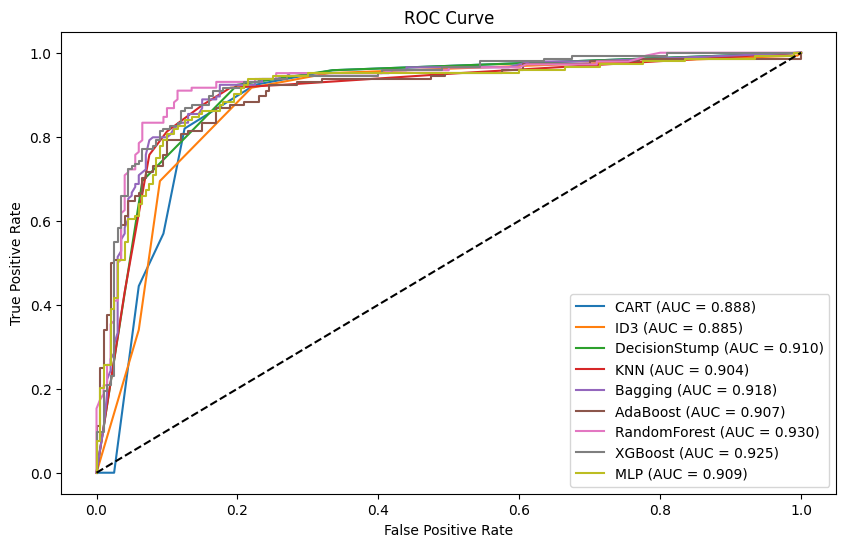

(           Model                                        Best Params  \
 0           CART                       {'classifier__max_depth': 3}   
 1            ID3                       {'classifier__max_depth': 3}   
 2  DecisionStump                       {'classifier__max_depth': 2}   
 3            KNN                     {'classifier__n_neighbors': 7}   
 4        Bagging                  {'classifier__n_estimators': 200}   
 5       AdaBoost                   {'classifier__n_estimators': 50}   
 6   RandomForest                  {'classifier__n_estimators': 300}   
 7        XGBoost                  {'classifier__n_estimators': 100}   
 8            MLP  {'classifier__activation': 'tanh', 'classifier...   
 
    Mean AUC Score  Std AUC Score  Execution Time (s)  
 0        0.888160       0.044847            0.309809  
 1        0.884705       0.050382            0.384671  
 2        0.909965       0.036814            0.244987  
 3        0.903628       0.049056            0.343445 

In [ ]:
run_classifiers(pipelines, X_train, y_train, X_test, y_test),

La courbe ROC évalue la performance d'un modèle en traçant le taux de vrais positifs (VP) contre le taux de faux positifs (FP) pour différents seuils. L'AUC, l'aire sous la courbe, mesure cette performance, avec une valeur proche de 1 indiquant un bon modèle.
